❗️ **本教程知识体系来源于**
**Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd edition**
**作者为Aurélien Géron**

**知识产权归原作者所有，如有侵权请联系删除**

# 动手做机器学习教程4 - 多种回归模型及其原理
>在本节，我们会从介绍线性回归模型背后的原理开始，接着介绍梯度下降算法和其他由线性回归引出的回归模型。

## 1.线性回归模型
通常情况下，线性回归模型如下所示：
$$\hat{y} = \theta_{0}+\theta_{1}x_{1}+...+\theta_{n}x_{n}$$

数据中共有n个特征(feature)，$x_{1}$-$x_{n}$是特征的值；$\theta_{0}$-$\theta_{n}$是模型的参数，其中$\theta_{0}$是偏置项(bias term)，$\theta_{1}$-$\theta_{n}$是权重(weight)；$\hat{y}$是最终的预测值。

若令$\pmb{\theta} = \left(\begin{matrix} \theta_{0}\\ \theta_{1}\\ \vdots\\ \theta_{n}\\ \end{matrix} \right)$，$\pmb{x} = \left(\begin{matrix} x_{0}\\ x_{1}\\ \vdots\\ x_{n}\\ \end{matrix} \right)$，其中$x_{0} = 1$，则上式可以表示为$\hat{y} = h_{\pmb{\theta}}(\pmb{x}) \triangleq \pmb{\theta}\bullet \pmb{x}$，这里"$\bullet$"是向量点积运算符。

在第2篇教程中，我们介绍了一种性能度量：均方根误差(RMSE)。$ RMSE(\pmb{\theta}) = \sqrt{\frac{1}{m} \sum_{i=1}^{m} ({\pmb{\theta}^{T}\pmb{x}^{(i)}-y^{(i)}})^{2}} $，其中$\pmb{\theta}^{T}$和$\pmb{x}^{(i)}$之间进行的是矩阵乘法运算。

接下来我们要介绍**均方误差(MSE)**：
$ MSE(\pmb{\theta}) = \frac{1}{m} \sum_{i=1}^{m} ({\pmb{\theta}^{T}\pmb{x}^{(i)}-y^{(i)}})^{2} $。事实上，使RMSE和MSE最小的$\pmb{\theta}$是相同的，并且在应用中我们更容易对进行优化，我们接下来会应用MSE进行模型的评分。

我们需要寻找使MSE最小的$\pmb{\theta}$（记为$\hat{\pmb{\theta}}$），好消息是线性回归存在封闭解(closed-form solution)，即我们能用数学公式显示表达$\hat{\pmb{\theta}}$：
$$\hat{\pmb{\theta}} = (\pmb{X}^{T}\pmb{X})^{-1}\pmb{X}^{T}\pmb{y}$$

注意到这个公式中进行的全部是矩阵乘法运算，我们将这个公式称为（最小二乘法的）正规方程(normal equation)。

我们看看如何在Python中应用正规方程，我们先生成一些类线性的数据：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
X = np.random.rand(100,1)
y = 2 + 5*X + np.random.randn(100,1)
plt.plot(X,y,"b.")
plt.axis([0,1,0,10])
plt.show()

<Figure size 640x480 with 1 Axes>

X是100行1列的[0,1)间的数据，y是由X经线性变换后又加上标准正态噪音而生成的数据。接下来我们将X的每个数据前都加上$x_{0} = 1$，这样便能带入正规方程了。

In [2]:
X_b = np.c_[np.ones((100,1)),X]
X_b[:5]

array([[1.        , 0.4711391 ],
       [1.        , 0.95827899],
       [1.        , 0.31050845],
       [1.        , 0.86448176],
       [1.        , 0.21909159]])

接下来我们用numpy.linalg来计算$\hat{\pmb{\theta}}$，其中**.T是求矩阵的转置，inv()是求矩阵的逆，dot()是矩阵乘法**：

In [3]:
theta_hat = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_hat

array([[1.91176444],
       [5.23543802]])

可以看到，$\hat{\pmb{\theta}}$和实际的系数(2,5)相差不多，我们将线性模型也画在图中：

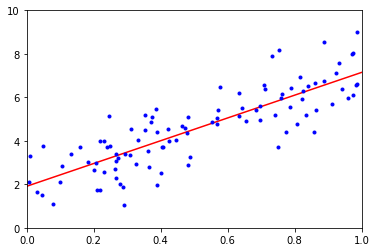

In [4]:
X_new = np.array([[0],[1]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_hat)
plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,1,0,10])
plt.show()

我们也可以用sklearn内置的线性模型来求$\hat{\pmb{\theta}}$和进行预测：

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([1.91176444]), array([[5.23543802]]))

In [6]:
lin_reg.predict(X_new)

array([[1.91176444],
       [7.14720246]])

## 2.梯度下降算法

我们可以将上例中的MSE称为代价函数(cost function)，我们需要寻找使代价函数取得最小值的一组参数$\hat{\pmb{\theta}}$。在实际中，很多代价函数没有封闭解，我们需要找另一种方法来尝试使代价函数取得最小值。一种常用的方法是**梯度下降算法(Gradient Descent)**，这种算法不仅适用于很多没有封闭解的代价函数，而且对于有封闭解的代价函数(如MSE)，其算法复杂度也比封闭解低，运算速度快。

在数学上，梯度(gradient)为一个向量，使得函数在该点处沿着梯度的方向变化率最大。若代价函数为$u = f(\theta_{0},...,\theta_{n})$，其在空间区域D内有一阶连续偏导数，$\pmb{\theta_{0}}$是D内任意一点，代价函数在该点的梯度$\nabla u(\pmb{\theta_{0}}) = (\frac{\partial f}{\partial \theta_{0}},...,\frac{\partial f}{\partial \theta_{n}})|_{\pmb{\theta_{0}}}$。**若某点的梯度的模为0，则该点一定为极值点。**我们可以利用梯度的这个性质来寻找代价函数的最小值点：

我们先随机取一组$\pmb{\theta}$，求出该点的梯度及函数值，用梯度找到新的一组$\pmb{\theta}$，使得新的函数值**小于**原函数值，直到某一组$\pmb{\theta}$使**梯度为0**，这样我们便找到了代价函数的一个极小值点。注意：**极小值点不一定是最小值点**，**最小值点也不一定是极小值点**！

如下图所示：假如$\pmb{\theta_{0}}$的取值范围是整个正半轴，最左边的极小值点明显不是最小值点，但梯度下降算法在找到极值点后将会停止运行，故从左边开始使用梯度下降算法将无法找到最小值点；假如$\pmb{\theta_{0}}$的取值范围是从原点到红线处，则红线处的$\pmb{\theta_{0}}$是最小值点，但其不是极小值点。

![InternetShortcut](F:\python\Jupyter\OpenBayes\4.最小值与极小值.PNG)


好在MSE是一个下凸函数(convex function)！下凸函数只有一个最小值点，这样梯度下降能保证找到最小值点，如下图所示：

![InternetShortcut](F:\python\Jupyter\OpenBayes\4.下凸函数.PNG)

### (1) 批量梯度下降
接下来我们要利用整个训练集进行梯度下降，因此称为批量梯度下降(batch gradient descent)。

我们可以在数学上推导出MSE的梯度表达式：$\nabla MSE(\pmb{\theta}) = \frac{2}{m}\pmb{X}^{T}(\pmb{X}\pmb{\theta}-\pmb{y})$。我们令由$\pmb{\theta}$寻找新的一组$\pmb{\theta}$（记为$\pmb{\theta}^{*}$）的算法如下：$\pmb{\theta}^{*} = \pmb{\theta} - \eta \nabla MSE(\pmb{\theta})$，其中$\eta$为学习率(learning rate)，其是一个超参数。

$\eta = 0.3$的代码实现如下：

In [7]:
eta = 0.3  
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[1.91176444],
       [5.23543802]])

学习率决定了机器学习时每两步之间的“距离”：若学习率过小，则可能需要很多步才能找到最小值点；若学习率过大，则可能会导致取的$\pmb{\theta}$在最小值点左右来回跳，并可能逐渐远离最小值点。我们作三张图来说明这一点，其中$\eta$分别为0.02、0.3、0.8：

In [8]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x$", fontsize=18)
    plt.axis([0, 1, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

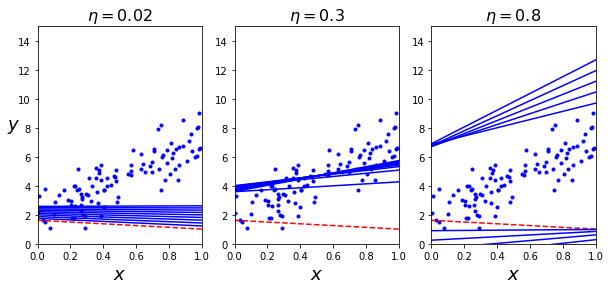

In [9]:
np.random.seed(1)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.3, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.8)

plt.show()

每一次学习的初始点由红线表示，在三次学习中，我们都进行了10次循环。我们发现$\eta = 0.02$时，学习率过小，导致机器在10次内无法找到正确的$\hat{\pmb{\theta}}$；$\eta = 0.8$时，学习率过大，导致机器在$\hat{\pmb{\theta}}$两端来回跳，$\pmb{\theta}$有发散的趋势。

为了找到合适的学习率，我们可以使用网格搜索(见第2篇教程)。

### (2) 随机梯度下降
批量梯度下降的主要问题便是其需要用到整个训练集来计算梯度，这在训练集很大时会导致很慢。随机梯度下降(stochastic gradient descent)会在每次循环时随机寻找一个$\pmb{\theta}$，只根据该点计算梯度，因此随机梯度下降**计算速度较快，但是其不能保证每一步代价函数值都会变小**。代价函数值会上下浮动，但总体来说会变小；代价函数值临近最小值时，其依然会上下浮动，因此当算法结束时，我们只能得到一个很“好”的$\pmb{\theta}$，而非最好的$\hat{\pmb{\theta}}$。当代价函数并非下凸函数时，我们可以用随机梯度下降，这样可能帮助算法“逃离”局部极小值而更靠近最小值。

如果我们在**每一步都合适地减小学习率**，则能使$\pmb{\theta}$在靠近最小值点时减小浮动，逐渐靠近$\hat{\pmb{\theta}}$，这种算法称为模拟退火(simulated annealing)。当然，我们不能太快地减小学习率，也不能太慢地减小学习率。

下面是模拟退火算法+随机梯度下降的应用：

In [10]:
n_epochs = 50
t0, t1 = 5, 50
m = len(X_b)

def learning_schedule(t): #我们用这个函数来使eta逐渐变小
    return t0 / (t + t1)

theta = np.random.randn(2,1) 

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
theta     

array([[1.99111164],
       [5.11601897]])

可以看到，用随机梯度下降得到的$\pmb{\theta}$并非$\hat{\pmb{\theta}}$，但是十分接近。我们在运行批量梯度下降时，循环了1000次，但是随机梯度下降只用了50次，并且得到了一个相当好的$\pmb{\theta}$。

我们也可以用sklearn的SGDRegressor来实现随机梯度下降。在这里，我们令最大循环次数(max_iter)为1000，容许误差(tol)为$10^{-3}$，不使用任何正则化调整(penalty=None)：

In [11]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.3)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([1.82424674]), array([5.15372058]))

### (3) 小批量梯度下降
如果我们每次循环都随机使用训练集的一个子集，并且其规模很小，则我们能获得比随机梯度下降结果更贴近最小值点的$\pmb{\theta}$，并且其运算速度比批量梯度下降更快。这种方法称为小批量梯度下降(mini-batch gradient descent)。小批量梯度下降在实际应用中很常见。

## 3.多项式回归模型

### (1) 多项式回归
如果我们的数据看起来不像一条直线，而像高次多项式，我们还能使用线性回归吗？答案是不能**直接**使用，但我们可以尝试使用sklearn的PolynomialFeature：

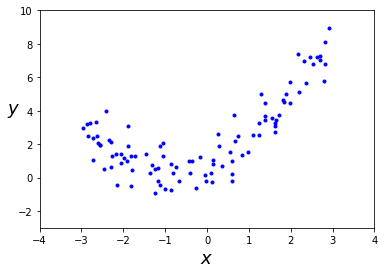

In [12]:
np.random.seed(42)
X = 6 * np.random.rand(100, 1) - 3
y = 0.5 * X**2 + X + 1 + np.random.randn(100, 1)
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-4, 4, -3, 10])
plt.show()

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly[:5]

array([[-0.75275929,  0.56664654],
       [ 2.70428584,  7.3131619 ],
       [ 1.39196365,  1.93756281],
       [ 0.59195091,  0.35040587],
       [-2.06388816,  4.25963433]])

我们利用PolynomialFeatures(degree=2)给X加上了第二列，第二列的值为第一列的平方，这样我们就可以应用线性回归了：

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([0.78134581]), array([[0.93366893, 0.56456263]]))

我们看到，得到的$\pmb{\theta}$和实际系数依然很接近，模型的贴合度很好。接下来我们根据$\pmb{\theta}$画出多项式模型：

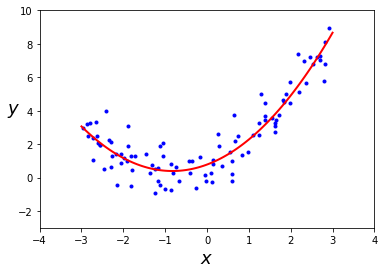

In [15]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-4, 4, -3, 10])
plt.show()

### (2) 学习曲线
X含有100个点，如果我们用100次多项式进行拟合，则我们能画出一条完全穿过所有点的曲线，但很明显这样是过拟合的一种了。如何检测我们的多项式是否过拟合？我们可以使用交叉验证，也可以使用学习曲线(learning curve)。学习曲线的y轴是模型在测试集和验证集上的性能度量(如RMSE)，x轴是训练集的大小。

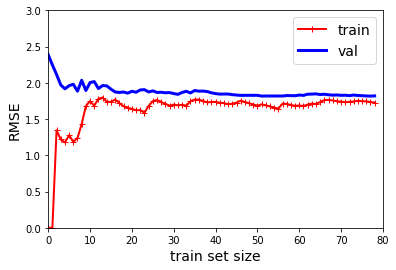

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("train set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                        
plt.show()

上图是对X进行线性回归拟合的学习曲线，红线为对训练集进行训练和评分，蓝线为对测试集进行测试和评分。我们知道，若对X进行线性拟合，则会发生欠拟合，欠拟合的学习曲线标志为：两条线最终均比较平缓，两线间距较小，RMSE均较大。若发生欠拟合，则我们需要使用更复杂的模型。

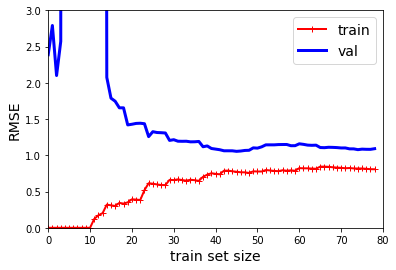

In [17]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
plt.show() 

上图是对X进行10次多项式回归拟合的学习曲线。此时发生过拟合，过拟合的学习曲线标志为：蓝线始终在红线上方,且始终有不小的间距，这表示模型在验证集上的效果比在测试集上的效果要差不少，这也是过拟合的一个标志。若发生过拟合，我们需要将测试集扩大，直到红线和蓝线最后比较贴近。

## 4.由线性回归引出的回归模型
如果我们对线性回归模型进行正则化(regularization)，则能减少过拟合，下面介绍的岭回归(ridge regression)、lasso回归(lasso regression)、弹性网络(elastic net)便是对线性回归正则化后的方法。它们都是对线性回归的权重$\pmb{\theta}$进行了约束。

### (1) 岭回归
岭回归是一种有偏回归，因此精度低于线性回归，但对共线性数据和病态数据的拟合要强于线性回归。

岭回归的代价函数为$J(\pmb{\theta}) = MSE(\pmb{\theta}) + \alpha \frac{1}{2}(\parallel \pmb{\theta} \parallel_{2})^{2} = MSE(\pmb{\theta}) + \alpha \frac{1}{2}\sum_{i=1}^{n} \theta_{i}^{2}$。如果$\alpha = 0$，则岭回归变为线性回归；如果$\alpha$非常大，则所有的$\theta_{i}$会贴近0，最后的结果是一条穿过数据平均值的横线。

岭回归的梯度为$\nabla J(\pmb{\theta}) = \frac{2}{m}\pmb{X}^{T}(\pmb{X}\pmb{\theta}-\pmb{y}) + \alpha \pmb{\theta}$，其封闭解为$\hat{\pmb{\theta}} = (\pmb{X}^{T}\pmb{X} + \alpha \pmb{A})^{-1}\pmb{X}^{T}\pmb{y}$，其中A为(n+1)阶单位矩阵将左上角的1改为0得到的矩阵。

我们可以用sklearn来实现岭回归：

In [18]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[3.82497007]])

我们也可以用随机梯度下降来实现岭回归：

In [19]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([3.80884129])

### (2) lasso回归
lasso回归的代价函数为$J(\pmb{\theta}) = MSE(\pmb{\theta}) + \alpha \parallel \pmb{\theta} \parallel_{1} = MSE(\pmb{\theta}) + \alpha \sum_{i=1}^{n} \mid \theta_{i} \mid$。

lasso回归倾向于将不重要的特征对应的权重设置为0，如若我们对X进行10次多项式拟合，再进行lasso回归，则$\theta_{0} - \theta_{2}$会比较贴近真实值，而$\theta_{3} - \theta_{10}$会很接近0。这样我们得到的模型是比较贴合数据的。

我们依旧可以用sklearn或随机梯度下降来实现lasso回归：

In [20]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([3.77621741])

In [21]:
sgd_reg = SGDRegressor(penalty="l1", max_iter=1000, tol=1e-3)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([3.80360114])

### (3) 弹性网络
弹性网络综合了岭回归和lasso回归，其代价函数为$J(\pmb{\theta}) = MSE(\pmb{\theta}) + r \alpha \sum_{i=1}^{n} \mid \theta_{i} \mid + + \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_{i}^{2}$。当$r = 0$时，弹性网络变为岭回归；当$r = 1$时，弹性网络变为lasso回归。

我们可以用sklearn实现弹性网络，其中l1_ratio即为r：

In [22]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([3.78114505])

通常情况下，我们不会使用线性回归，而是使用岭回归。如果你怀疑数据集中只有一些特征是有用的，便可以使用lasso回归或弹性网络。而若特征数量比训练集数据数量多或一些特征相关性很强，我们会选择弹性网络而非lasso回归。

## 参考资料：
* “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd edition”  作者：Aurélien Géron
